## Initializations: Skip to the next section

<span style="color:red;">TODO</span>: Fix problems

In [16]:
%matplotlib inline

In [17]:
from ipywidgets.widgets import Image
from IPython.display import display, display_svg, display_png

In [18]:
# xxxxxxxxxx Add the parent folder to the python path. xxxxxxxxxxxxxxxxxxxx
import sys
parent_dir = "../"
sys.path.append(parent_dir)
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# xxxxxxxxxx Import Statements xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
from time import time
from time import sleep
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt

from pyphysim.simulations.runner import SimulationRunner
from pyphysim.simulations.parameters import SimulationParameters
from pyphysim.simulations.results import SimulationResults, Result
from pyphysim.simulations.simulationhelpers import simulate_do_what_i_mean
from pyphysim.simulations.runner import get_common_parser
from pyphysim.modulators.fundamental import PSK
from pyphysim.channels import pathloss
from pyphysim.channels import multiuser
from pyphysim.util.conversion import dB2Linear, linear2dB
from pyphysim.cell.cell import Cluster
from pyphysim.util import misc
from pyphysim.util.conversion import dBm2Linear
from pyphysim.ia import algorithms
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

## Set the parameters, create the cluster and the channels, etc

/home/darlan/miniconda3/envs/ml/lib/python3.7/site-packages/IPython/core/formatters.py:371: FormatterWarning: image/svg+xml formatter returned invalid type <class 'bytes'> (expected <class 'str'>) for object: Cluster(cell_radius=1.0,num_cells=19,pos=0j,cluster_id=None,cell_type='simple',rotation=0.0)
  FormatterWarning


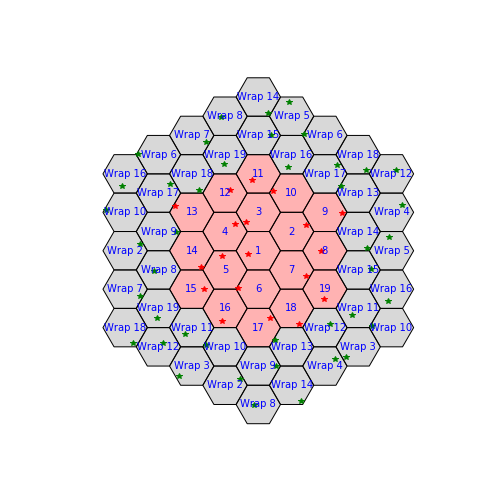

In [19]:
multiUserChannel = multiuser.MultiUserChannelMatrix()
#ia_solver = algorithms.MMSEIASolver(multiUserChannel)
ia_solver = algorithms.MaxSinrIASolver(multiUserChannel)
#ia_solver = algorithms.AlternatingMinIASolver(multiUserChannel)
ia_solver.max_iterations = 500

modulator = PSK(4)

include_path_loss_bool = True

M = 4
NSymbs = 100
K = 19
Nr = 4
Nt = 8
Ns = 2
SNR = 30.0
users_per_cell = 1

# Cluter variables
cell_radius = 1.0

# Dependent parameters
#noise_var = 1 / dB2Linear(SNR)
noise_var = dBm2Linear(-116.4)

# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# xxxxxxxxxx Create the cluster of cells xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
cluster = Cluster(cell_radius=cell_radius, num_cells=19)
cluster.create_wrap_around_cells(include_users_bool=True)
cluster.add_random_users(cell_ids=range(1,20), num_users=users_per_cell)
#cluster.add_border_users(cell_ids=range(1,20), angles=0, ratios=0.01)
cluster.figsize = (7,7)
cluster.fill_face_bool = True
cluster.fill_opacity = 0.3
cluster
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

## Calculate the distances between each user and each base station

In [20]:
multiUserChannel.randomize(Nr, Nt, K)

if include_path_loss_bool is True:
    # xxxxxxxxxx Calculate the pathloss for each link xxxxxxxxxxxxxxxxxxxxx
    dists = cluster.calc_dist_all_users_to_each_cell()
    #pl_obj = pathloss.PathLossFreeSpace()
    pl_obj = pathloss.PathLoss3GPP1()
    #pl_obj = pathloss.PathLossOkomuraHata()
    # Calculate the path loss in linear scale
    pl = pl_obj.calc_path_loss(dists)

    #pl = np.eye(19)
    multiUserChannel.set_pathloss(pl)
else:
    # Path loss will be equal to 1.0 for all links
    pl = np.ones([K,K])
    multiUserChannel.set_pathloss(None)

## Plot the distances

In [21]:
# fig, axs = plt.subplots(10,2, figsize=(12,40))
# for row in range(10):
#     for col in range(2):
#         index = 2 * row + col
#         if index > 18:
#             break
# #         print "{0}: {1}x{2}".format(index, row, col)
#         axs[row, col].set_xlim([0, 20])
#         axs[row, col].grid()
#         axs[row, col].plot(range(1,20), dists[index])
#         axs[row, col].plot(index+1, dists[index][index], 'or')
#         axs[row, col].xaxis.set_ticks(np.arange(1,20))
# plt.show()

## Calculate the Transmit power of each user

In [22]:
# Calculate the transmit power of each user
snr = dB2Linear(SNR)
Pt = snr * noise_var/pl.diagonal()

## Path Loss of the Interference Links relative to the direct link

In [23]:
pl_dB = -linear2dB(pl)
np.set_printoptions(precision=1, linewidth=140)

for index in range(19):
    pl_dB[index] = pl_dB[index] - pl_dB[index][index]

print('Relative Direct Channel Path Loss:\n{0}'.format(pl_dB.diagonal()))
print('Relative Max Path Loss:\n{0}'.format(pl_dB.max(axis=1)))
print('Relative Min Path Loss:\n{0}'.format(np.sort(pl_dB, axis=1)[:,1]))
print()
np.set_printoptions(precision=4, linewidth=120)
# print np.mean(np.sort(pl_dB, axis=1)[:,1])
# print np.mean(pl_dB.max(axis=1))

Relative Direct Channel Path Loss:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Relative Max Path Loss:
[34.3 34.2 31.  35.7 33.5 28.1 34.3 55.8 36.9 32.1 45.4 52.1 36.8 32.4 39.7 40.6 37.  35.6 45.4]
Relative Min Path Loss:
[15.7  5.3  5.9 12.1  8.8  1.1  5.5 33.4 14.2  2.4 19.3 28.2 16.1  4.3 13.1 17.8  7.4 13.8 20. ]



## Question: How many interference links are strong enough?

First we need to ask ourselves what is a good measurement that we can use to say that a interference link is strong enough or not. The easiest one is probably the path loss.

If we count the number of interference links that have a relative path loss when compared with the direct channel of less than 30dB we get

In [24]:
[(sum(pl_dB[i] < 30) - 1) for i in range(19)]

[10, 13, 16, 12, 14, 18, 13, 0, 9, 15, 3, 1, 8, 15, 8, 7, 10, 9, 3]

However, notice that the relative path loss is only one side of the coint. We still need to account the transmit power of each interfering base station when compared with the transmit power of our own base station. That is, if the relative path loss to some interference link is 25dB, but that particular base station transmit with 10dB more power than our own base station then the relative interference power of that link when compared with the desired signal would be 15dB.

## Find the IA Solution

In [25]:
noise_var

2.29086765276777e-15

In [26]:
assert abs(ia_solver.noise_var - noise_var) < 1e-12
ia_solver.clear()
runned_reps = ia_solver.solve(Ns=Ns, P=Pt)
print(runned_reps)

500


Some of the precoders may have 0 energy.

In [27]:
data = []
for f in ia_solver.full_F:
    data.append(np.linalg.norm(f, 'fro')**2)
    print(data[-1])
    
print
data = np.array(data)
#print("Number of non zero links: {0}".format(len(data[data > 1e-3])))
print("Sum Capacity: {0}\nxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx".format(ia_solver.calc_sum_capacity()))

0.9604421670730849
4.516205092615985
4.213612039041268
1.6753912618348237
2.8602276826379627
11.416501417793139
4.429767340251117
0.03454405925708655
6.209480782301019
8.569036643705973
0.5231728880719113
0.09562745607773986
6.733560243914742
7.6245202968151595
1.714565428393206
1.738900575979215
3.4264667115329193
6.2012728294383415
0.6857485645831303
Sum Capacity: 277.35609429618717
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


Pos Processing SINR for each Stream

In [28]:
print("Input SNR: {0}".format(SNR))

print("Post-processing SINRs")
for v in ia_solver.calc_SINR_in_dB():
    print(v)

Input SNR: 30.0
Post-processing SINRs
[15.985  19.5998]
[22.9611 25.0722]
[16.6826 20.2383]
[21.0026 19.8173]
[20.2778 21.7965]
[28.9149 30.5519]
[25.4505 23.6476]
[16.0943 12.7103]
[26.4294 23.9707]
[24.1517 27.1644]
[18.7868 18.7593]
[15.4836 19.1192]
[29.3825 26.6757]
[23.8751 22.2008]
[17.9444 19.0788]
[21.0559 18.8886]
[26.335  20.3721]
[27.8352 25.0798]
[19.0664 20.851 ]


In [29]:
# # If any of the Nr, Nt or Ns variables were integers (meaning all
# # users have the same value) we will convert them by numpy arrays
# # with correct size (K).
# Nr = ia_solver.Nr
# Nt = ia_solver.Nt
# Ns = ia_solver.Ns

# cumNs = np.cumsum(ia_solver.Ns)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxx Input Data xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# # inputData has the data of all users (vertically stacked)
# inputData = np.random.randint(0, M, [np.sum(Ns), NSymbs])
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxx Modulate input data xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# # modulatedData has the data of all users (vertically stacked)
# modulatedData = modulator.modulate(inputData)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxxxxxxx Perform the Interference Alignment xxxxxxxxxxxxxxxxxxx
# # Split the data. transmit_signal will be a list and each element
# # is a numpy array with the data of a user
# transmit_signal = np.split(modulatedData, cumNs[:-1])
# transmit_signal_precoded = map(np.dot, ia_solver.full_F, transmit_signal)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxx Pass through the channel xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# multi_user_channel = ia_solver._multiUserChannel
# # received_data is an array of matrices, one matrix for each receiver.
# #import pudb; pudb.set_trace()  ## DEBUG ##

# received_data = multi_user_channel.corrupt_data(
#     transmit_signal_precoded, noise_var)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxx Perform the Interference Cancelation xxxxxxxxxxxxxxxxxxxxxx
# received_data_no_interference = map(np.dot,
#                                     ia_solver.full_W_H, received_data)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxx Demodulate Data xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# received_data_no_interference = np.vstack(received_data_no_interference)
# demodulated_data = modulator.demodulate(received_data_no_interference)
# # demodulated_data = map(modulator.demodulate, received_data_no_interference)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxx Calculates the symbol and bit error rates xxxxxxxxxxxxxxxxx
# symbolErrors = np.sum(inputData != demodulated_data)
# bitErrors = misc.count_bit_errors(inputData, demodulated_data)
# numSymbols = inputData.size
# numBits = inputData.size * modulators.level2bits(M)
# ia_cost = ia_solver.get_cost()
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # xxxxxxxxxx Calculates the Sum Capacity xxxxxxxxxxxxxxxxxxxxxxxxxx
# sirn_all_k = ia_solver.calc_SINR()
# calc_capacity = lambda sirn: np.sum(np.log2(1 + sirn))
# # Array with the sum capacity of each user
# sum_capacity = map(calc_capacity, sirn_all_k)
# # Total sum capacity
# total_sum_capacity = np.sum(sum_capacity)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# #xxxxxxxxxx Number of iterations of the IA algorithm xxxxxxxxxxxxxx
# ia_runned_iterations = ia_solver.runned_iterations
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


# # Print the results
# print("SumCapacity: {0}".format(total_sum_capacity))
# print("BER: {0}".format(float(bitErrors)/numBits))


# # xxxxx Return the simulation results xxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# symbolErrorsResult = Result.create(
#     "symbol_errors", Result.SUMTYPE, symbolErrors)

# numSymbolsResult = Result.create(
#     "num_symbols", Result.SUMTYPE, numSymbols)

# bitErrorsResult = Result.create("bit_errors", Result.SUMTYPE, bitErrors)

# numBitsResult = Result.create("num_bits", Result.SUMTYPE, numBits)

# berResult = Result.create("ber", Result.RATIOTYPE, bitErrors, numBits,
#                           accumulate_values=False)

# serResult = Result.create(
#     "ser", Result.RATIOTYPE, symbolErrors, numSymbols, accumulate_values=False)

# ia_costResult = Result.create(
#     "ia_cost", Result.RATIOTYPE, ia_cost, 1, accumulate_values=False)

# sum_capacityResult = Result.create(
#     "sum_capacity", Result.RATIOTYPE, total_sum_capacity, 1,
#     accumulate_values=False)

# ia_runned_iterationsResult = Result.create(
#     "ia_runned_iterations", Result.RATIOTYPE, ia_runned_iterations, 1, accumulate_values=False)

# #import pudb; pudb.set_trace()  ## DEBUG ##

# simResults = SimulationResults()
# simResults.add_result(symbolErrorsResult)
# simResults.add_result(numSymbolsResult)
# simResults.add_result(bitErrorsResult)
# simResults.add_result(numBitsResult)
# simResults.add_result(berResult)
# simResults.add_result(serResult)
# simResults.add_result(ia_costResult)
# simResults.add_result(sum_capacityResult)
# simResults.add_result(ia_runned_iterationsResult)
# # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# # return simResults